In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import sys
import pandas as pd
import numpy as np
import math
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt
from utilities import *

### Data import & filter

In [48]:
#Read from txt and xlsx and filter
proteins = pd.read_csv('proteinGroups.txt', index_col='id', delimiter = '\t')
#filter and keep the replicates separate
proteins = remove_cont_and_nan(proteins)
# Filtering non human proteins from the main file
proteins['genename'] = proteins['Gene names'].str.split(';').str[0]
proteins['Fastas'] = proteins['Fasta headers'].str.split(';')
#read uniprot human data
uniprot_human = pd.read_csv('uniprot_human_gn.tab.tsv', sep = '\t')
uniprot_human_list = uniprot_human.Entry.tolist()
#check if protein group includes human protein
for i in proteins.index:
    gns = []
    ids = proteins.at[i,'Majority protein IDs']
    ids = ids.split(';')
    for k,identifier in enumerate(ids):
        if identifier in uniprot_human_list:
            gn = uniprot_human[uniprot_human['Entry'] == identifier]['Gene names'].tolist()[0]
            if type(gn) == str:
                gns.append(gn.split(';')[0].split(' ')[0])
    if gns != []: #update if there is at least one protein
        proteins.at[i,'Human_GN'] = gns[0] #there are 108 protein groups with multiple names, reduce it by seleting the first one
#select the protein id of main list and replicates
proteins['UniprotID'] = proteins['Protein IDs'].str.split(';').str[0]
#normalizing the protein ratios by median & reverse the ratio to L/H
#for combined
proteins['Normalized Ratio L/H'] = -1*np.log2(proteins['Ratio H/L'] / proteins['Ratio H/L'].median())
#and replicates
proteins['Normalized Ratio L/H IEF1_1'] = -1*np.log2(proteins['Ratio H/L IEF1_1'] / proteins['Ratio H/L IEF1_1'].median())
proteins['Normalized Ratio L/H IEF1_2'] = -1*np.log2(proteins['Ratio H/L IEF1_2'] / proteins['Ratio H/L IEF1_2'].median())
proteins['Normalized Ratio L/H IEF2_1'] = -1*np.log2(proteins['Ratio H/L IEF2_1'] / proteins['Ratio H/L IEF2_1'].median())
proteins['Normalized Ratio L/H IEF2_2'] = -1*np.log2(proteins['Ratio H/L IEF2_2'] / proteins['Ratio H/L IEF2_2'].median())

## Significant proteins and distribution of Normalized H/L ratios

In [49]:
#Find significantly up and down regulated proteins
#90% confidence interval edian absoulute deviation
median = proteins['Normalized Ratio L/H'].median()
MAD = np.absolute(proteins['Normalized Ratio L/H']-median).median() * 1.4826
proteins['significant'] = np.absolute(proteins['Normalized Ratio L/H']-median)/MAD > 1.645
#select the significats and save
significants = proteins[(proteins['significant'] == True)]
significants.to_csv('Significants_90.txt', sep='\t', index=False)
#export all proteins with the significance and normalized ratio
proteins.to_csv('proteins_all_90.txt', sep='\t', index=False)

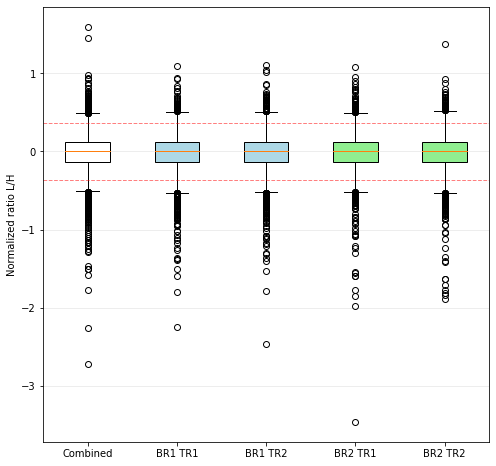

In [50]:
#LH distribution boxplots
data_to_plot = [proteins["Normalized Ratio L/H"], proteins["Normalized Ratio L/H IEF1_1"].dropna(),proteins["Normalized Ratio L/H IEF1_2"].dropna(),
                proteins["Normalized Ratio L/H IEF2_1"].dropna(),proteins["Normalized Ratio L/H IEF2_2"].dropna()]
fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot,patch_artist=True, sym='o')
plt.axhline(linewidth=1, color='r', y=-0.369705664139553, linestyle='--', alpha=0.5)
plt.axhline(linewidth=1, color='r', y=0.36958625, linestyle='--', alpha=0.5)
ax.set_xticklabels(['Combined', 'BR1 TR1', 'BR1 TR2', 'BR2 TR1', 'BR2 TR2'])
ax.set_ylabel("Normalized ratio L/H")
colors = ['white', 'lightblue','lightblue', 'lightgreen','lightgreen']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
# Save the figure
fig.savefig('LH_boxplot_normalized.svg', bbox_inches='tight')

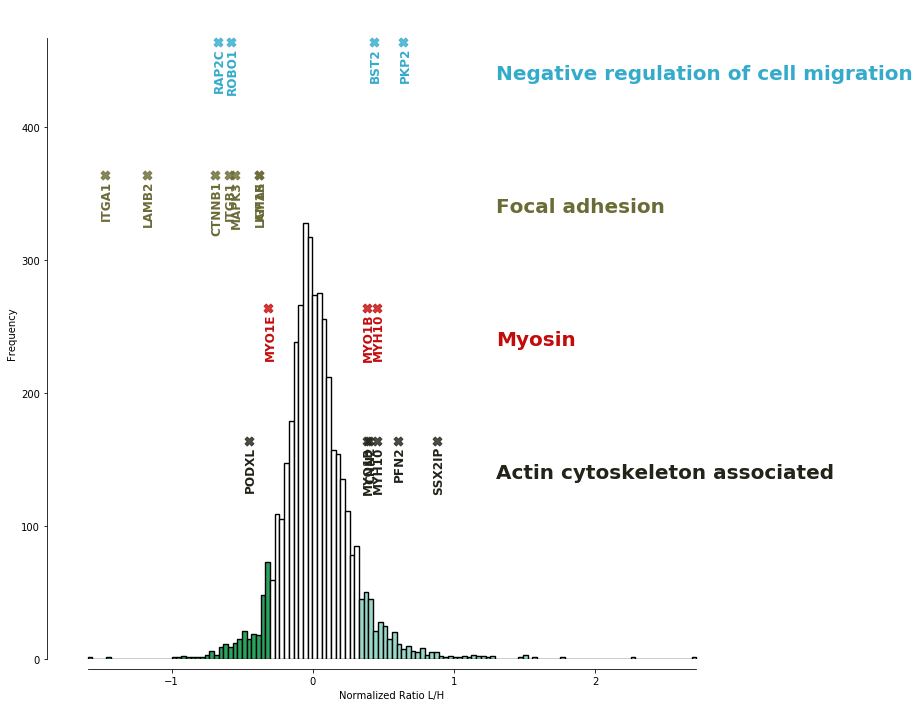

In [51]:
#LH histogram combined
#up- and down-regulated lists
ups = significants[(significants['Normalized Ratio L/H'] > 0)]
downs = significants[(significants['Normalized Ratio L/H'] < 0)]
num_bins = 130
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
n, bins, patches = ax.hist(-1*proteins["Normalized Ratio L/H"], num_bins, density=0, facecolor='white', alpha=1, linewidth=1.4, edgecolor='black')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
ax.set_xlabel('Normalized Ratio L/H')
ax.set_ylabel('Frequency')
#color up and down
for c, p in zip(bins, patches):
    if c >= min(ups["Normalized Ratio L/H"]):
        plt.setp(p, 'facecolor', '#99D8C9')
    if c <= max(downs["Normalized Ratio L/H"]):
        plt.setp(p, 'facecolor', '#2CA25F')
#print terms to highlight
colors = ['#23231A', '#C40B0B', '#6B6B37', '#35ABCC', '#FFFF00']
markers = ['X']* len(colors)
terms = {'Negative regulation of cell migration': ['RAP2C', 'ROBO1', 'BST2', 'PKP2'],
         'Focal adhesion': ['ITGA1', 'LAMB2', 'CTNNB1', 'ITGB1', 'MAPK3', 'IGF1R', 'LAMA5'],
         'Myosin':['MYO1B', 'MYO1E', 'MYH10'],
         'Actin cytoskeleton associated':['MYH10', 'MYO1B', 'SSX2IP', 'PFN2', 'PODXL', 'CNN2']}      
def add_point(gene_name,ratio,color, previous_ratios, previous_genes, ofset=0, mar = '1', start=160):
    '''adds proteins to the histogram'''
    if gene_name != previous_genes:
        ax.scatter(ratio,start+4+ofset*4, c=color, alpha=0.8, marker=mar,s=80)
        ax.text(ratio+0.01, start+ofset*4, gene_name, rotation=90, fontsize=12, ha='center', va='top', color=color, weight='bold')
        #ax.annotate(gene_name, (ratio, 200+ofset))
    else:
        ax.scatter(ratio,100+ofset, c= color, alpha=0.8, marker=mar,s=60)
previous_ratios = []
previous_proteins = []
proteins_d = proteins.dropna(subset=['Gene names'])
start = 140
for i,term in enumerate(['Actin cytoskeleton associated','Myosin','Focal adhesion','Negative regulation of cell migration']):
    for j,protein in enumerate(terms[term]):
        ratio = float(proteins_d[proteins_d['Gene names'].str.contains(protein).dropna()]['Normalized Ratio L/H'])
        add_point(protein,ratio,colors[i], previous_ratios,previous_proteins, ofset=i*25, mar = markers[i])
        previous_ratios.append(ratio)
        previous_proteins.append(protein)
    ax.text(1.3, start+i*(25*4), term, rotation=0, fontsize=20, ha='left', va='center',
                color= colors[i],weight = 'bold')    
#adjust spines
adjust_spines(ax, ['left', 'bottom'])
plt.savefig('HL_combined_histogram_GOs_10percent_biggerfont_sized.svg')
proteins.to_csv('proteins_all_LH.txt', sep = '\t', index = False)

## Correlation of biological replicates

In [52]:
proteins_br1 = pd.read_excel('IEF1_7_1.xlsx', index_col='id', delimiter = '\t')
proteins_br2 = pd.read_excel('IEF2 7_5 with new analysis.xlsx', index_col='id', delimiter = '\t')
proteins_br1 = remove_cont_and_nan(proteins_br1)
proteins_br2 = remove_cont_and_nan(proteins_br2)

#proteins_br1['genename'] = proteins_br1['Gene names'].str.split(';').str[0]
#proteins_br1['UniprotID'] = proteins_br1['Protein IDs'].str.split(';').str[0]
#proteins_br2['genename'] = proteins_br2['Gene names'].str.split(';').str[0]
#proteins_br2['UniprotID'] = proteins_br2['Protein IDs'].str.split(';').str[0]

proteins_br1['Normalized Ratio L/H'] = -1*np.log2(proteins_br1['Ratio H/L'] / proteins_br1['Ratio H/L'].median())
proteins_br1['Normalized Ratio L/H 1'] = -1*np.log2(proteins_br1['Ratio H/L 1'] / proteins_br1['Ratio H/L 1'].median())
proteins_br1['Normalized Ratio L/H 2'] = -1*np.log2(proteins_br1['Ratio H/L 2'] / proteins_br1['Ratio H/L 2'].median())
proteins_br2['Normalized Ratio L/H'] = -1*np.log2(proteins_br2['Ratio H/L'] / proteins_br2['Ratio H/L'].median())
proteins_br2['Normalized Ratio L/H 1'] = -1*np.log2(proteins_br2['Ratio H/L 1'] / proteins_br2['Ratio H/L 1'].median())
proteins_br2['Normalized Ratio L/H 2'] = -1*np.log2(proteins_br2['Ratio H/L 2'] / proteins_br2['Ratio H/L 2'].median())

## Correlation of technical replicates
### BR1: TR1 and TR2

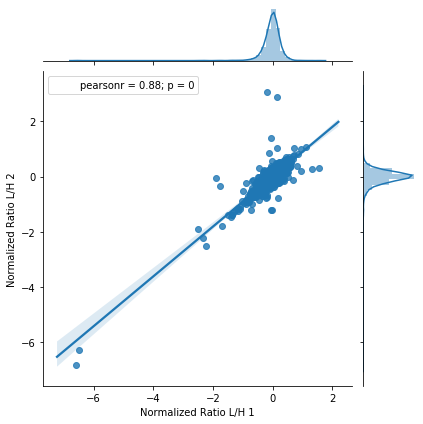

In [181]:
#BR1: TR1 and TR2
br1_tr1_tr2 = sns.jointplot(x="Normalized Ratio L/H 1", y="Normalized Ratio L/H 2", data=proteins_br1, kind="reg")
br1_tr1_tr2.annotate(stats.pearsonr)
plt.savefig('BR1_TR1&TR2_correlation.svg')

### BR2: TR1 and TR2

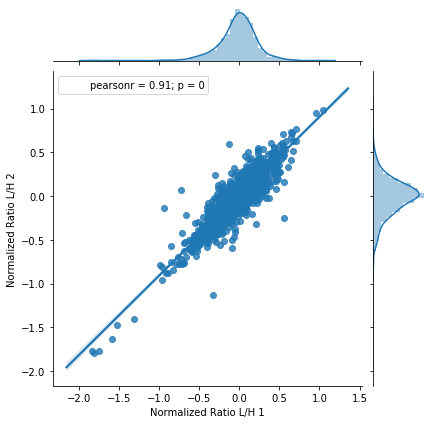

In [182]:
#BR2: TR1 and TR2
br2_tr1_tr2 = sns.jointplot(x="Normalized Ratio L/H 1", y="Normalized Ratio L/H 2", data=proteins_br2, kind="reg")
br2_tr1_tr2.annotate(stats.pearsonr)
plt.savefig('BR2_TR1&TR2_correlation.svg')

### Compare BR1 and BR2

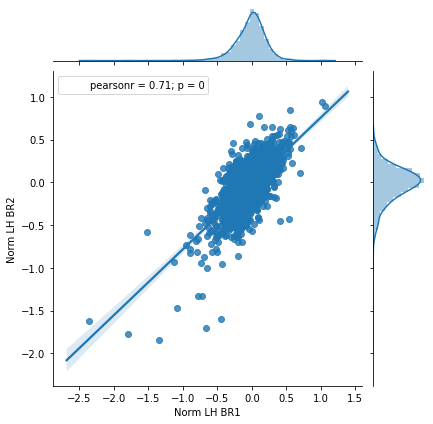

In [63]:
# Compare BR1 and BR2 (maxquant report of the main combined protein list)
proteins['Norm LH BR1'] = (proteins['Normalized Ratio L/H IEF1_1'] + proteins['Normalized Ratio L/H IEF1_2']) / 2
proteins['Norm LH BR2'] = (proteins['Normalized Ratio L/H IEF2_1'] + proteins['Normalized Ratio L/H IEF2_2']) / 2
g=sns.jointplot(x="Norm LH BR1", y="Norm LH BR2", data=proteins, kind="reg")
g.annotate(stats.pearsonr)
plt.savefig('BR1&BR2_correlation.svg')
# Corr. of seperate analysis
#br_merged = proteins_br1.merge(proteins_br2, left_on="Protein IDs", right_on="Protein IDs")
#sns.jointplot(x="Normalized Ratio L/H_x", y="Normalized Ratio L/H_y", data=br_merged, kind="reg")

## Summary table

In [183]:
summary_df = {"Protein Groups": [len(proteins[["Ratio H/L IEF1_1", "Ratio H/L IEF1_2"]].dropna()),
                                 len(proteins[["Ratio H/L IEF2_1", "Ratio H/L IEF2_2"]].dropna())],
              "Protein groups common to both replicates": proteins["Ratio H/L"].count(),
              "Significantly regulated proteins: H vs L": sum(proteins["significant"]==True),
              "Singificant proteins in Light label": len(proteins[(proteins["significant"]) & (proteins["Normalized Ratio L/H"]>0)]),
              "Singificant proteins in Heavy label": len(proteins[(proteins["significant"]) & (proteins["Normalized Ratio L/H"]<0)]) 
             
             }

In [184]:
summary_df

{'Protein Groups': [3002, 2277],
 'Protein groups common to both replicates': 4094,
 'Significantly regulated proteins: H vs L': 666,
 'Singificant proteins in Light label': 267,
 'Singificant proteins in Heavy label': 399}